In [1]:
!pip install lightgbm

### Packages

In [2]:
#requirements !pip freeze > requirements.txt.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Load and Organise data

## Import data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort3/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## Pre-process variables

In [4]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [5]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']
# list(set(df.columns) - set(output_variable) - set(cat_variables))

### Mapping categorical variables to one-hot encoding

In [6]:
animals = ["cat", "dog", "cat", "dog"]
# one-hot encoding
animals_cat = [1, 0, 1, 0]
animals_dog = [0, 1, 0, 1]
animals_not_cat = [0, 1, 0, 1]

# integer encoding
animals_int = [1, 2, 1, 2]

# binary encoding
animals = ["cat", "dog", "cat", "dog", "rat", "bat"]
animals_0 = [0,     0,    0,      0,     1,     1]
animals_1 = [0,     1,    0,      1,     0,     1]

In [7]:
np.ceil(np.log2(9))

4.0

In [8]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# quick check
df_cat.mean()

account_check_status_0 <= ... < 200 DM                                        0.269
account_check_status_< 0 DM                                                   0.274
account_check_status_>= 200 DM / salary assignments for at least 1 year       0.063
account_check_status_no checking account                                      0.394
credit_history_all credits at this bank paid back duly                        0.049
credit_history_critical account/ other credits existing (not at this bank)    0.293
credit_history_delay in paying off in the past                                0.088
credit_history_existing credits paid back duly till now                       0.530
credit_history_no credits taken/ all credits paid back duly                   0.040
purpose_(vacation - does not exist?)                                          0.050
purpose_business                                                              0.097
purpose_car (new)                                                           

In [9]:
df_cat.shape

(1000, 54)

In [10]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


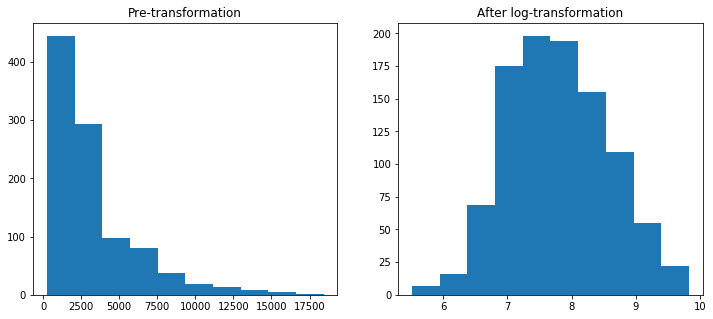

In [11]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df[["credit_amount"]]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df[["credit_amount"]]), columns=["log(credit)"])

## Consolidating a final dataset

In [12]:
df_model = pd.concat([df[int_variables], df_cat, df_age, df_log, df[output_variable]], axis=1)
df.shape, df_model.shape

((1000, 21), (1000, 66))

In [13]:
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,67,1169,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,22,5951,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,49,2096,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,45,7882,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,53,4870,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


# Modelling

## Quick modelling with Tree-based Model

In [14]:
df_model[output_variable].describe()

,default
count,1000.000000
mean,0.300000
std,0.458487
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [15]:
# separate data
X, y = df_model.drop(labels=output_variable, axis=1), df_model[output_variable]

# fit model
from sklearn.tree import DecisionTreeClassifier
class_tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
#class_tree = DecisionTreeClassifier(max_depth=2, criterion="gini", class_weight="balanced")
class_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Getting node variables + Plotting Decision Tree

In [16]:
from sklearn.tree import export_graphviz
export_graphviz(class_tree, out_file="class_tree.dot", feature_names=X.columns, 
                class_names = ["No Default", "Default"], rounded = True)

#### go to http://webgraphviz.com/ and paste class_tree.dot text

### Some exploratory analysis

In [17]:
pd.crosstab(X["account_check_status_no checking account"] <=0.5, y[output_variable[0]]==1)

default,False,True
account_check_status_no checking account,,
False,348,46
True,352,254


Text(0.5, 0, 'duration_in_month')

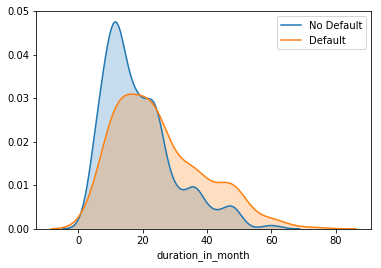

In [18]:
nodefault_duration = X.loc[((y.values == 0) & 
                            (X["account_check_status_no checking account"].values.reshape(-1, 1) <= 0.5)).reshape(1, -1)[0], 
                           "duration_in_month"]
default_duration = X.loc[((y.values == 1) & 
                          (X["account_check_status_no checking account"].values.reshape(-1, 1) <= 0.5)).reshape(1, -1)[0], 
                         "duration_in_month"]
ax = sns.kdeplot(nodefault_duration, shade=True, shade_lowest=False, label="No Default")
ax = sns.kdeplot(default_duration, shade=True, shade_lowest=False, label="Default")
ax.set_xlabel("duration_in_month")

Text(0.5, 0, 'credit_amount')

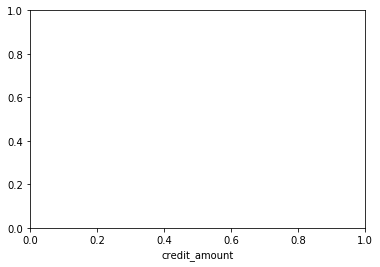

In [19]:
nodefault_duration = X.loc[((y.values == 0) & 
                            (X["credit_amount"].values.reshape(-1, 1) <= 0.5)).reshape(1, -1)[0], 
                           "credit_amount"]
default_duration = X.loc[((y.values == 1) & 
                          (X["credit_amount"].values.reshape(-1, 1) <= 0.5)).reshape(1, -1)[0], 
                         "credit_amount"]
ax = sns.kdeplot(nodefault_duration, shade=True, shade_lowest=False, label="No Default")
ax = sns.kdeplot(default_duration, shade=True, shade_lowest=False, label="Default")
ax.set_xlabel("credit_amount")

In [20]:
X["credit_amount"]

0       1169
1       5951
2       2096
3       7882
4       4870
5       9055
6       2835
7       6948
8       3059
9       5234
10      1295
11      4308
12      1567
13      1199
14      1403
15      1282
16      2424
17      8072
18     12579
19      3430
20      2134
21      2647
22      2241
23      1804
24      2069
25      1374
26       426
27       409
28      2415
29      6836
       ...  
970     1514
971     7393
972     1193
973     7297
974     2831
975     1258
976      753
977     2427
978     2538
979     1264
980     8386
981     4844
982     2923
983     8229
984     2028
985     1433
986     6289
987     1409
988     6579
989     1743
990     3565
991     1569
992     1936
993     3959
994     2390
995     1736
996     3857
997      804
998     1845
999     4576
Name: credit_amount, Length: 1000, dtype: int64

## Cross-validating Tree-Based Model

### Initial Params

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 10-fold cv
k_folds = StratifiedKFold(n_splits=10, random_state=10)

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss}

# model
# model = DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=10)
model = DecisionTreeClassifier(max_depth=12, criterion="gini", class_weight="balanced", random_state=10)

### Fit model

In [25]:
# pre-allocation
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
df_metrics = pd.DataFrame(index=range(10), columns=perf_metrics.keys())

# main loop
k = 0
for (train, test) in k_folds.split(X, y):
    # fit model
    model.fit(X[train], y[train])
       
    # test model
    ypred_class = model.predict(X[test])
    ypred_prob = model.predict_proba(X[test])[:, 1]

    # compute performance metrics
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            df_metrics.loc[k, pf] = perf_metrics[pf](y[test], ypred_prob)
        else:
            df_metrics.loc[k, pf] = perf_metrics[pf](y[test], ypred_class)
    k += 1

### Show results

In [26]:
df_metrics.mean()

Accuracy     0.696000
Precision    0.501164
Recall       0.606667
AUC          0.676095
F1-Score     0.545311
Brier        0.278542
dtype: float64

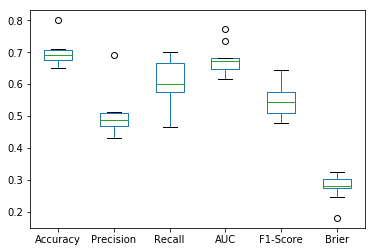

In [28]:
df_metrics.plot(kind="box")

## Hyper-parameter tuning + Cross-validation: GBT

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# params
k_folds = StratifiedKFold(n_splits=10, random_state=10) # k-fold
hyper_params = {"learning_rate": [10.0 ** -2, 10.0 ** -1, 10.0 ** 0],
                "max_depth": [1, 2, 3],
                "max_features": [0.1, 0.25, 0.5],
                "n_estimators": [200]
                }

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss}

for pf in perf_metrics:
    perf_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

# main method
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
model = GridSearchCV(estimator=GradientBoostingClassifier(random_state=10), 
                     param_grid=hyper_params, 
                     scoring=perf_metrics, 
                     cv=k_folds, 
                     refit="F1-Score")
model.fit(X, y.ravel())

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-pack

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-pack

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.01, 0.1, 1.0], 'max_depth': [1, 2, 3], 'max_features': [0.1, 0.25, 0.5], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit='F1-Score',
       return_train_score='warn',
       scoring={'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score), 'AUC': make_scorer(roc_auc_score), 'F1-Score': make_scorer(f1_sc

### Show results

In [34]:
# get best model
best_model = model.best_estimator_
best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=2,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
# store all results and avg results in a df
df_cv = pd.DataFrame(model.cv_results_)

# add a hyperparameter column in avg df
from sklearn.model_selection import ParameterGrid
df_hyperparams = pd.DataFrame(list(ParameterGrid(model.param_grid)))
df_avgcv = pd.DataFrame(columns=perf_metrics.keys())
for pf in perf_metrics.keys():
    df_avgcv[pf] = df_cv["mean_test_" + pf]
df_avgcv = pd.concat([df_hyperparams, df_avgcv], axis=1)

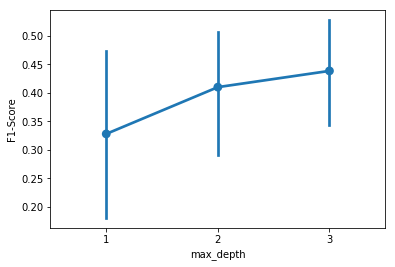

In [36]:
sns.pointplot(x="max_depth", y="F1-Score", data=df_avgcv)

In [37]:
df_avgcv.loc[df_avgcv["F1-Score"].idxmax()]

learning_rate      1.000000
max_depth          2.000000
max_features       0.500000
n_estimators     200.000000
Accuracy           0.750000
Precision          0.587487
Recall             0.550000
AUC                0.692857
F1-Score           0.566142
Brier              0.250000
Name: 23, dtype: float64

### Feature Importance chart

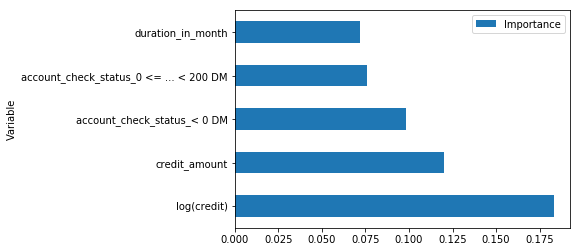

In [38]:
df_featimp = pd.DataFrame({"Variable": df_model.drop(output_variable, axis=1).columns,
                           "Importance": best_model.feature_importances_})
df_featimp = df_featimp.sort_values("Importance", ascending=False)

# chart
df_featimp.iloc[:5].plot(x="Variable", y="Importance", kind="barh")

### Partial dependency plot

In [3]:
from sklearn.inspection import plot_partial_dependence
fig, ax = plt.subplots(figsize=(10, 10))
plot_partial_dependence(best_model, X, df_featimp.iloc[:5].index, 
                        feature_names=df_featimp.iloc[:5]["Variable"], fig=fig, 
                        response_method="predict_proba", method="brute", grid_resolution=200) 

C:\Users\Koshiyama\Anaconda3\envs\mli3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 112 from C header, got 124 from PyObject
  return f(*args, **kwds)


NameError: name 'plt' is not defined

In [ ]:
df_model.corr()["credit_amount"].loc["duration_in_month"]

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_partial_dependence(best_model, X, [(df_featimp.index[0], df_featimp.index[1])], 
                        feature_names=df_featimp["Variable"], fig=fig, 
                        response_method="predict_proba", method="brute")

# Other Topics

## Scalable models

### Create dataset with different sizes

In [ ]:
# small
df_model_small = df_model.copy()

# medium
for k in range(10):
    if k==0:
        df_model_medium = df_model.copy()
    else:
        df_model_medium = pd.concat([df_model_medium, df_model.copy()], axis=0, ignore_index=True)
        
# large
for k in range(100):
    if k==0:
        df_model_large = df_model.copy()
    else:
        df_model_large = pd.concat([df_model_large, df_model.copy()], axis=0, ignore_index=True)

### GBT

In [ ]:
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1), 
                                                 df_model_small[output_variable])
print(time() - start)

# medium
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1), 
                                                 df_model_medium[output_variable])
print(time() - start)

# large
start = time()
GradientBoostingClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1), 
                                                 df_model_large[output_variable])
print(time() - start)

### LightGBM - https://lightgbm.readthedocs.io/en/latest/index.html

In [4]:
from lightgbm import LGBMClassifier
from time import time
from sklearn.ensemble import GradientBoostingClassifier
# small
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_small.drop(output_variable, axis=1), 
                                                 df_model_small[output_variable])
print(time() - start)

# medium
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_medium.drop(output_variable, axis=1), 
                                                 df_model_medium[output_variable])
print(time() - start)

# large
start = time()
LGBMClassifier(n_estimators=100).fit(df_model_large.drop(output_variable, axis=1), 
                                                 df_model_large[output_variable])
print(time() - start)

ModuleNotFoundError: No module named 'lightgbm'